# Tracking Snooker Balls
Submitted by: Dima Nirenshteyn

---

The following code will get a static video of a snooker video, detect objects on the table, filter objects & try to find balls and their colors, then project the results on a generated 2D version of the snooker table. 

### imports:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Functions:

In [2]:
width, height = 280, 560 # size of output image (few functions use it)

#### `create_table()`:

creates `width`x`height` 2D snooker table image.

* input: 
        None

* output: 
        image

---
designing the table:

every snooker table has a line and half a circle in one of its sides.

according to this __[link](https://www.snookerbilliardspool.co.uk/TableMarking.asp)__, the markdowns are:


the **line** is 
$$ \frac{height}{5} $$


 the **circle** is in the middle of the line and its radius is 
 $$ \frac{width}{3} $$

In [3]:
def create_table():
    
    # new generated img 
    img = np.zeros((height,width,3), dtype=np.uint8) # create 2D table image 
    img[:, :] = [0, 180, 10] # setting RGB colors to green pool table color, (0,180,10)=certain green
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    
    # create circle in the right size
    cv2.circle(img, (int(width/2),int(height/5)), # center of circle
               int((width/3)/2), # radius
               (50,255,50)) # color
    
    # delete half of circle by coloring in green color
    img[int(height/5):height,0:width] = [0, 180, 10] 
    # create line
    cv2.line(img,(0,int(height/5)),(width,int(height/5)),(50,255,50)) 
    
    return img

---

#### `draw_holes(img)`:

draws borders & holes on 2D snooker table image and returns it.

* input: 
        image, 2D generated table

* output: 
        image, 2D generated table + holes & borders

---
(for cosmetics) makes a copy of the input image to use it as a canvas, draws circles that look like holes, returns the canvas image.  

In [4]:
def draw_holes(input_img, color3 = (200,140,0)):
        
    color = (190, 190, 190) # gray color
    color2 = (120, 120, 120) #  gray color, for circles (holes) on generated img

    img = input_img.copy() # make a copy of input image
    
    # borders 
    cv2.line(img,(0,0),(width,0),color3,3) # top
    cv2.line(img,(0,height),(width,height),color3,3) # bot
    cv2.line(img,(0,0),(0,height),color3,3) # left
    cv2.line(img,(width,0),(width,height),color3,3) # right
    
    # adding circles to represent holes on table
    cv2.circle(img, (0, 0), 11,color, -1) # top right
    cv2.circle(img, (width,0), 11, color, -1) # top left
    cv2.circle(img, (0,height), 11, color, -1) # bot left
    cv2.circle(img, (width,height), 11, color, -1) # bot right
    cv2.circle(img, (width,int(height/2)), 8, color, -1) # mid right
    cv2.circle(img, (0,int(height/2)), 8, color, -1) # mid left
    
    # adding another, smaller circles to the previous ones
    cv2.circle(img, (0, 0), 9,color2, -1) # top right
    cv2.circle(img, (width,0), 9, color2, -1) # top left
    cv2.circle(img, (0,height), 9, color2, -1) # bot left
    cv2.circle(img, (width,height), 9, color2, -1) # bot right
    cv2.circle(img, (width,int(height/2)), 6, color2, -1) # mid right
    cv2.circle(img, (0,int(height/2)), 6, color2, -1) # mid left
    
    return img

---

#### `draw_balls(ctrs,background,radius,size,img)`:

gets contours and finds their center & color, then draws balls for each contour on canvas image and returns the canvas image.


* input:
       - ctrs: contours
       - background: image to draw on. (new 2D table by default).
       - radius: radius of the drawn balls.
       - size: size of line. (-1 by default to fill).
       - img: image which the contours are taken from

* output: 
        image, with drawn snooker balls

---
first, using moments, calculates (x,y) of each contour center.

next, masks each contour (ball) and calculates its average inner color.

finely, draws circles that look like a snooker ball for each contour. (one circle for inner color of ball, one for a black border of ball and one for small light reflection)

In [5]:
def draw_balls(ctrs,background = create_table(), radius=7, size = -1, img = 0):

    K = np.ones((3,3),np.uint8) # filter
    
    final = background.copy() # canvas
    mask = np.zeros((560, 280),np.uint8) # empty image, same size as 2d generated final output
    
    
    for x in range(len(ctrs)): # for all contours
        
        # find center of contour
        M = cv2.moments(ctrs[x])
        cX = int(M['m10']/M['m00']) # X pos of contour center
        cY = int(M['m01']/M['m00']) # Y pos
        
        # find color average inside contour
        mask[...]=0 # reset the mask for every ball 
        cv2.drawContours(mask,ctrs,x,255,-1) # draws mask for each contour
        mask =  cv2.erode(mask,K,iterations = 3) # erode mask several times to filter green color around balls contours
        
        
        # balls design:
        
        
        # circle to represent snooker ball
        final = cv2.circle(final, # img to draw on
                           (cX,cY), # position on img
                           radius, # radius of circle - size of drawn snooker ball
                           cv2.mean(img,mask), # color mean of each contour-color of each ball (src_img=transformed img)
                           size) # -1 to fill ball with color
        
        # add black color around the drawn ball (for cosmetics)
        final = cv2.circle(final, (cX,cY), radius, 0, 1) 
        
        # small circle for light reflection
        final = cv2.circle(final, (cX-2,cY-2), 2, (255,255,255), -1)
         
        

        
    return final

---

#### `filter_ctrs(ctrs,min_s,max_s,alpha)`:

gets contours and filters them by their size and shape, then returns filtered contours.


* input:
       - ctrs: contours
       - min_s: min area size of accepted contour
       - max_s: max area size of accepted contour
       - alpha: parameter to find wanted shape

* output: 
        contours

---
calculates rectangle around each contour, widht and height of rectangle and contours area. 

then if a contour is in the right size $(min > area < max)$ and in the right shape (check with `alpha`), it means the contour is most likely a ball.



**alpha** is just a parameter that helps to filter objects by their shapes

lets say `alpha = 2`:

then if `contour[i]` is ($height*2 < width$) or ($width*2 < height$) , its **not** a ball.

\* 3.445 by default in this model after testing different values.

In [6]:
def filter_ctrs(ctrs, min_s = 90, max_s = 358, alpha = 3.445):  
    
    filtered_ctrs = [] # list for filtered contours
    
    for x in range(len(ctrs)): # for all contours
        
        rot_rect = cv2.minAreaRect(ctrs[x]) # area of rectangle around contour
        w = rot_rect[1][0] # width of rectangle
        h = rot_rect[1][1] # height
        area = cv2.contourArea(ctrs[x]) # contour area 

        
        if (h*alpha<w) or (w*alpha<h): # if the contour isnt the size of a snooker ball
            continue # do nothing
            
        if (area < min_s) or (area > max_s): # if the contour area is too big/small
            continue # do nothing 

        # if it failed previous statements then it is most likely a ball
        filtered_ctrs.append(ctrs[x]) # add contour to filtered cntrs list

        
    return filtered_ctrs # returns filtere contours

---

#### `find_balls(src)`:

gets a frame (of snooker table), applies several methods to detect the balls and returns 2D top view with drawn, colored balls


* input:
        src: image, frame from snooker video

* output: 
        image: 2D top view

---
warps perspective of the input image, blurs, finds table's mask, filters the mask (closing), invert mask, finds and filters contours, draws balls on canvas image and returns the canvas image.



In [7]:
def find_balls(src):
    final = create_table()
    
    # warp perspective
    matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by 4 points of each image
    transformed = cv2.warpPerspective(src, matrix, (width,height)) # warps perpective to new image

    # apply blur
    transformed_blur = cv2.GaussianBlur(transformed,(5,5),cv2.BORDER_DEFAULT) # blur applied
    blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

    # mask
    hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
    mask = cv2.inRange(hsv, lower, upper) # table's mask

    # filter mask
    kernel = np.ones((5,5),np.uint8)
    mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode
    
    # apply threshold
    ret,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # apply threshold
       
    # create image with masked objects on table 
    masked_objects = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image

    # find contours and filter them
    ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
    ctrs = filter_ctrs(ctrs) # filter contours by sizes and shapes

    # draw table+balls
    final = draw_balls(ctrs,radius=8,img=transformed) # draw all found contours  
    final = draw_holes(final) # draw holes
    
    return final

---

#### `find_ctrs_color(ctrs,input_img)`:

gets image (of snooker table), applies several methods to detect the balls and returns 2D top view with drawn, colored balls


* input:
        ctrs: contours
        input_img: image that the contours are taken from

* output: 
        image, black image with large colored circle for each contour

---
masks each contour (ball), erodes the mask to clear some of the green color around the contour, draws the contour with its calculated inner color and returns an image of the colored contours with a black background.



In [8]:
def find_ctrs_color(ctrs, input_img):

    K = np.ones((3,3),np.uint8) # filter
    output = input_img.copy() #np.zeros(input_img.shape,np.uint8) # empty img
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) # gray version
    mask = np.zeros(gray.shape,np.uint8) # empty mask

    for i in range(len(ctrs)): # for all contours
        
        # find center of contour
        M = cv2.moments(ctrs[i])
        cX = int(M['m10']/M['m00']) # X pos of contour center
        cY = int(M['m01']/M['m00']) # Y pos
    
        mask[...]=0 # reset the mask for every ball 
    
        cv2.drawContours(mask,ctrs,i,255,-1) # draws the mask of current contour (every ball is getting masked each iteration)

        mask =  cv2.erode(mask,K,iterations=3) # erode mask to filter green color around the balls contours
        
        output = cv2.circle(output, # img to draw on
                         (cX,cY), # position on img
                         20, # radius of circle - size of drawn snooker ball
                         cv2.mean(input_img,mask), # color mean of each contour-color of each ball (src_img=transformed img)
                         -1) # -1 to fill ball with color
    return output

---

#### `draw_rectangles(ctrs,img)`:

gets image (of snooker table), draws a rectangle around each contour.


* input:
        ctrs: contours
        input_img: image that the contours are taken from

* output: 
        image, same as input image but with rectangles on contours.

---
by using moments, finds width and height of each contour, draws a rectangle around each contour on a canvas image and returns the canvas image. 



In [9]:
def draw_rectangles(ctrs, img):
    
    output = img.copy()
    
    for i in range(len(ctrs)):
    
        M = cv2.moments(ctrs[i]) # moments
        rot_rect = cv2.minAreaRect(ctrs[i])
        w = rot_rect[1][0] # width
        h = rot_rect[1][1] # height
        
        box = np.int64(cv2.boxPoints(rot_rect))
        cv2.drawContours(output,[box],0,(255,100,0),2) # draws box
        
    return output

---

## Code starts here:

we will save a few different frames (`frame2`,`frame3`,`frame4`) with different situations for later use.

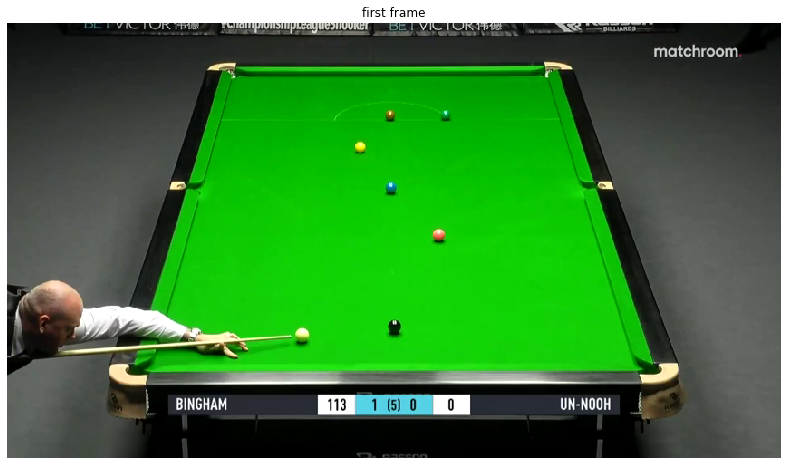

In [10]:
name = 'P6_Snooker.mp4'

# first frame from the original video
cap = cv2.VideoCapture(name)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # take first frame

# loop frames and take few different frames for later
for i in range(1430):
    ret, frame2 = cap.read() # frame2 = the 1430th frame (frame example #1)
    if i == 1050:
        frame3 = frame2.copy() # frame3 = the 1000th frame (frame example #2)
    if i == 263:
        frame4 = frame2.copy() # frame4 = the 263th frame (frame example #3)
        
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB) 
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB) 
frame4 = cv2.cvtColor(frame4, cv2.COLOR_BGR2RGB) # another frames

plt.figure(figsize=(16,8))
plt.imshow(frame)
plt.title('first frame')
plt.axis('off')
plt.show()

to warp the perspective of the image we need to 'select' the table, which is our region of interest.

it is possible by marking the 4 points on the corners of the table and then warp the perspective to wanted image.

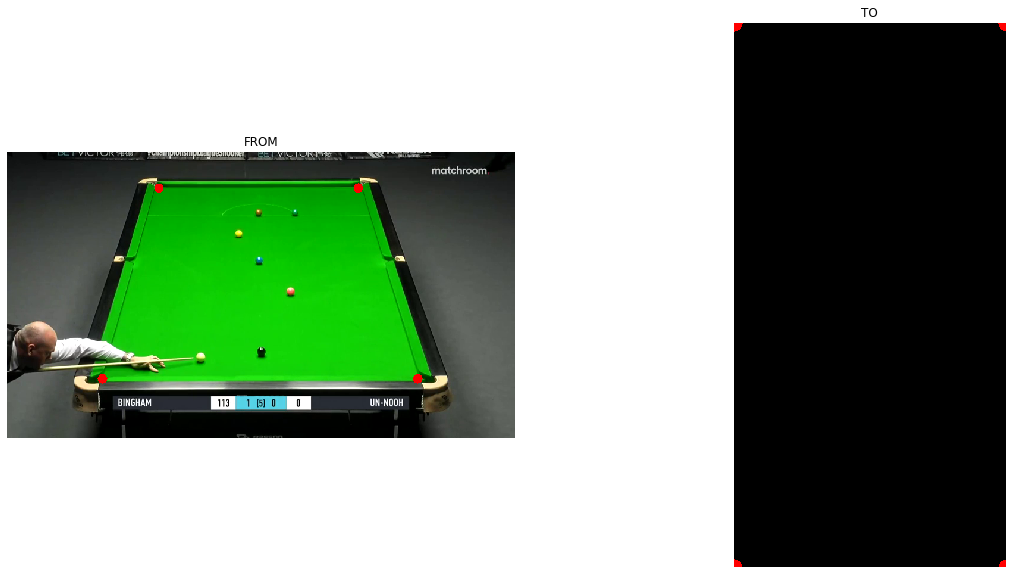

In [11]:
# visualization:

# red points on corners of original table
table = frame.copy() # add points to pool table corners
cv2.circle(table, (160, 380), 8, 255, -1) # bot left
cv2.circle(table, (690, 380), 8, 255, -1) # bot right
cv2.circle(table, (255, 60), 8, 255, -1) # top left
cv2.circle(table, (590, 60), 8, 255, -1) # top right

# red points on corners of generated table
img = np.zeros((height,width,3), dtype=np.uint8)
new_img = img.copy() # add points to edges of img
cv2.circle(new_img, (0,0), 8, 255, -1) # bot left
cv2.circle(new_img, (width,0), 8, 255, -1) # bot right
cv2.circle(new_img, (0,height), 8, 255, -1) # top left
cv2.circle(new_img, (width,height), 8, 255, -1) # top right

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(table)
plt.title('FROM')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(new_img)
plt.title('TO')
plt.axis('off')
plt.show()

using points of both images we can get the perspective and warp it

In [12]:
# creating points of original data and new generated img
pts1 = np.float32([ [255, 60],[590, 60],[160, 380],[690, 380] ]) # 4 corners points of ORIGINAL image
pts2 = np.float32([ [0,0],[width,0],[0,height],[width,height] ]) # 4 corners points of OUTPUT image

matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by 4 points of each image
transformed = cv2.warpPerspective(frame, matrix, (width,height)) # warps perpective to new image

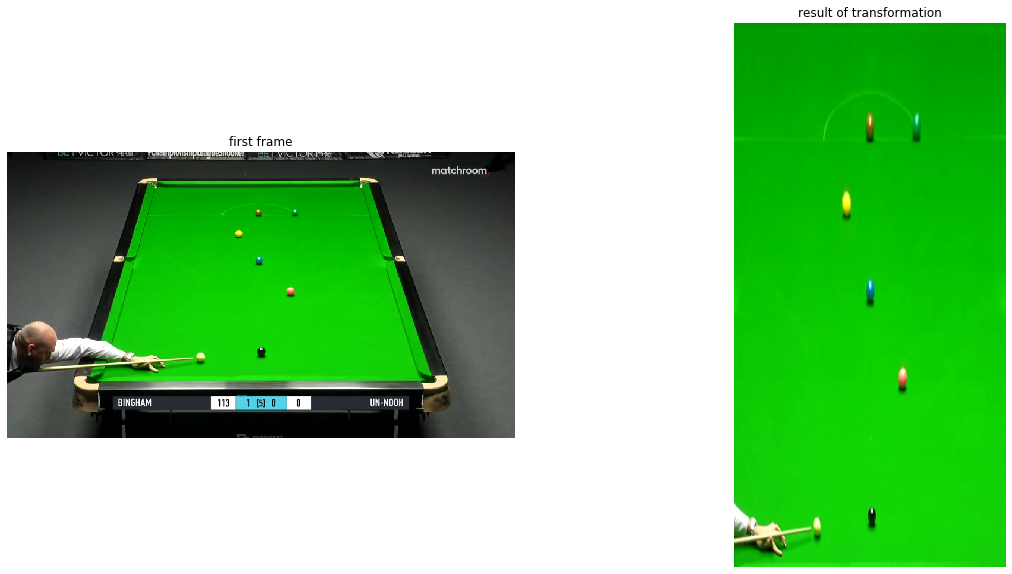

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('first frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(transformed)
plt.title('result of transformation')
plt.axis('off')
plt.show()

#### Create mask of snooker table by using HSV and `inRange`

By using mask we can "throw" out the table and then analyze all what is left.


create a mask by using the HSV color range of the snooker table, then invert the mask to get a mask of objects on the table.

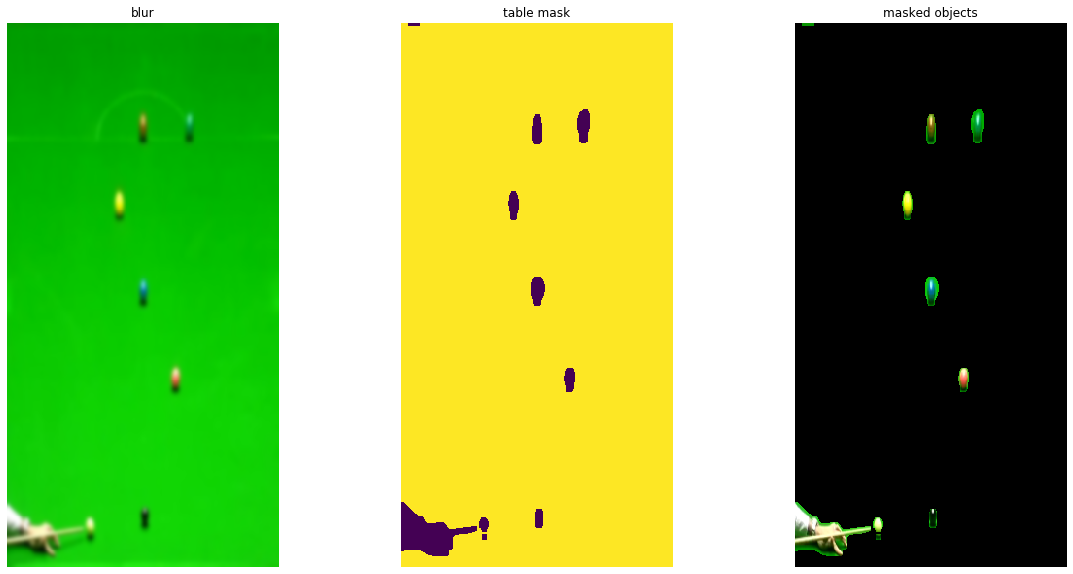

In [14]:
transformed_blur = cv2.GaussianBlur(transformed,(0,0),2) # blur applied
blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

# hsv colors of the snooker table
lower = np.array([60, 200,150]) 
upper = np.array([70, 255,240]) # HSV of snooker green: (60-70, 200-255, 150-240) 

hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
mask = cv2.inRange(hsv, lower, upper) # table's mask

# apply closing
kernel = np.ones((5,5),np.uint8)
mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode

# invert mask to focus on objects on table
_,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # mask inv

masked_img = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image with inverted mask

# plot edges, threshold, filter
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(transformed_blur)
plt.title('blur')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_closing)
plt.title('table mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(masked_img) 
plt.title('masked objects')
plt.axis('off')
plt.show()

now by using contours, for example, we can detect all the objects in the image, filter them, calculate their center, and find their colors.

we are going to find contours using the inverted mask, use `draw_rectangles()` to draw rectangles around contours before filtering them, then filter them with `filter_ctrs()` and draw rectangles around the filtered contours aswell.

next, using `find_ctrs_color()` we will find the average inner color inside each contour and show results.

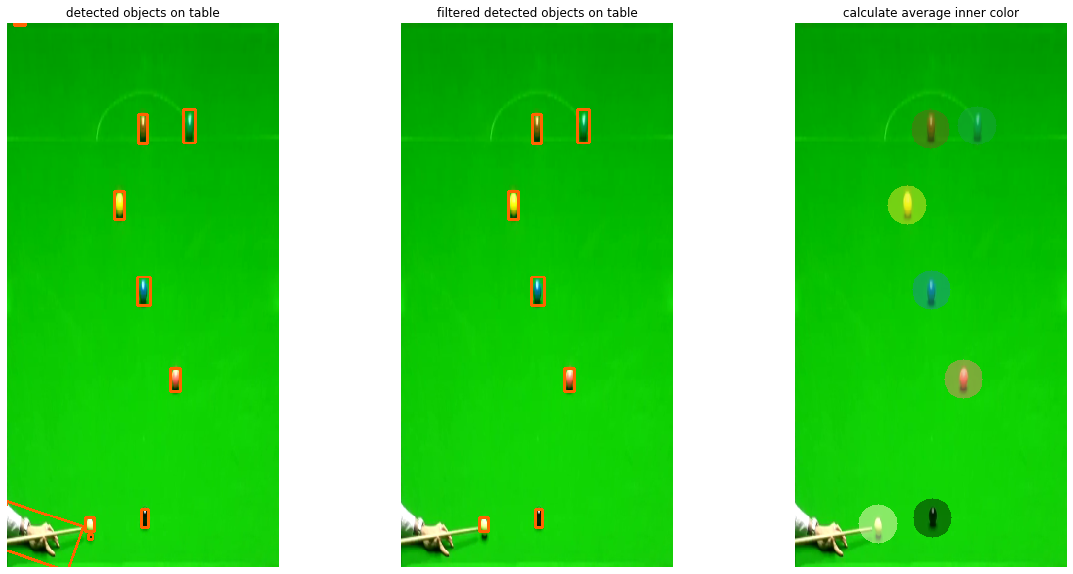

In [15]:
# find contours and filter them
ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # create contours in filtered img

# draw contours before filter
detected_objects = draw_rectangles(ctrs, transformed) # detected objects will be marked in boxes

ctrs_filtered = filter_ctrs(ctrs) # filter unwanted contours (wrong size or shape)

# draw contours after filter
detected_objects_filtered = draw_rectangles(ctrs_filtered, transformed) # filtered detected objects will be marked in boxes

# find average color inside contours:
ctrs_color = find_ctrs_color(ctrs_filtered, transformed)
ctrs_color = cv2.addWeighted(ctrs_color,0.5,transformed,0.5,0) # contours color image + transformed image

# plot results
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(detected_objects)
plt.title('detected objects on table')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(detected_objects_filtered)
plt.title('filtered detected objects on table')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(ctrs_color)
plt.title('calculate average inner color')
plt.axis('off')
plt.show()

Now that we have center and color of each contour, we can generate the 2-D "top view" of the game

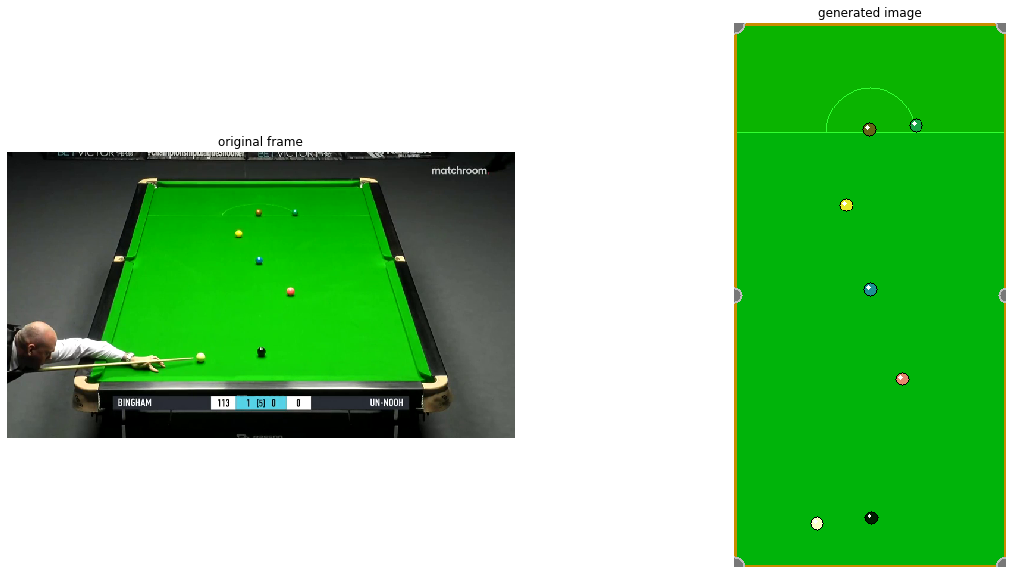

In [16]:
# design of the 2D generated table
final = draw_balls(ctrs_filtered,img=transformed) # gets contours and draws balls in their centers
final = draw_holes(final) # draws holes in the 2D img

 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(final)
plt.title('generated image')
plt.axis('off')
plt.show()

In this frame, the balls have been successfully detected, but the model does not know position of balls and does not remember balls locations, it only projects 'what it sees' no matter how many balls or what colors they are.


overall, it can detect balls on a snooker table, find their color and project the results on a 2D top view generated image.

---

Lets watch what happens in different situations with few other frames from the video:


#### Example #1

cases where balls are hidden behind objects

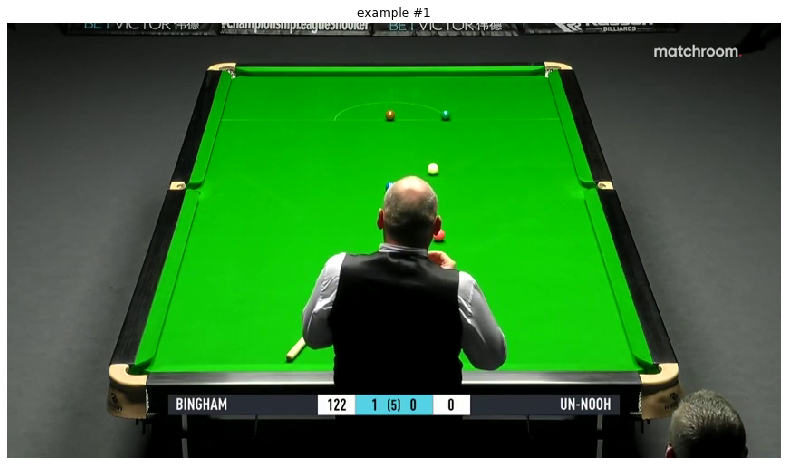

In [17]:
plt.figure(figsize=(16,8))
plt.imshow(frame2)
plt.title('example #1')
plt.axis('off')
plt.show()

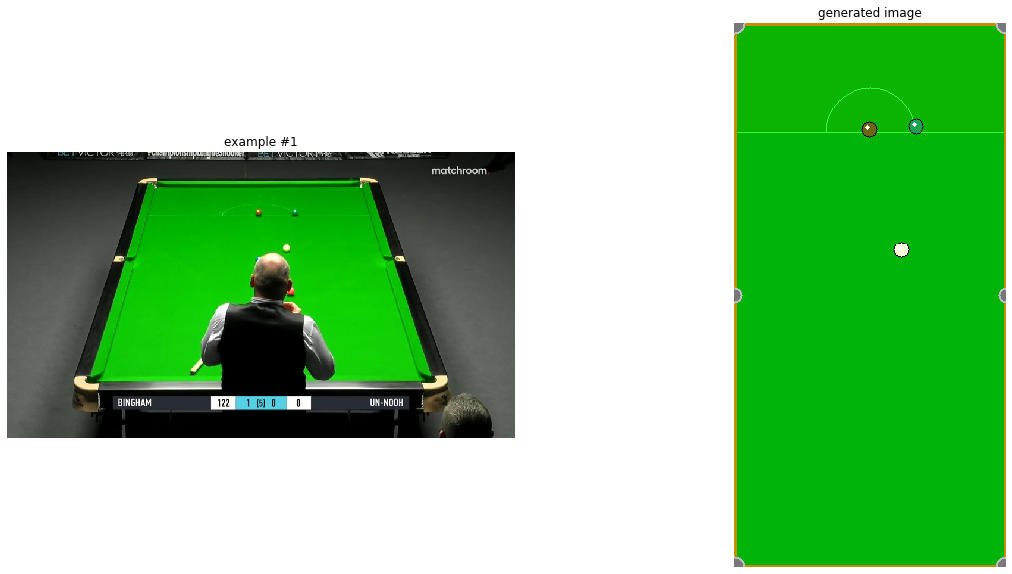

In [18]:
frame2_detect = find_balls(frame2) # find balls in frame2

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame2)
plt.title('example #1')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(frame2_detect)
plt.title('generated image')
plt.axis('off')
plt.show()

#### * Hidden balls:

Unsees balls which are hiding behind different objects will remain undetected until they will be visible again.

---

lets try another frame:

#### Example #2

cases where ball is harder to detect

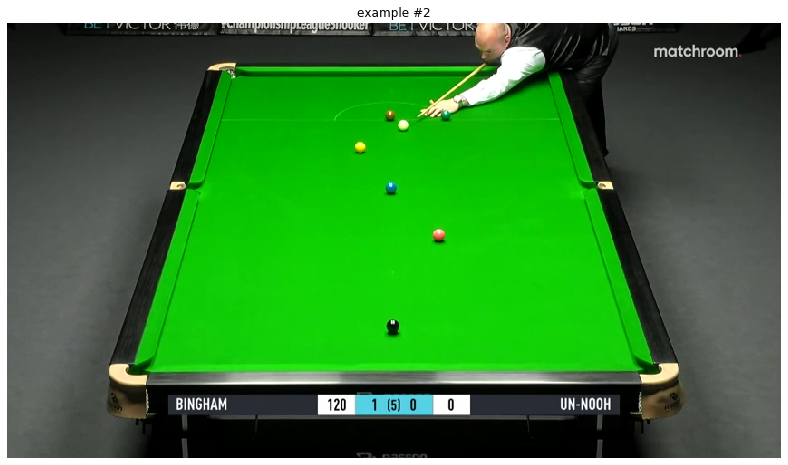

In [19]:
plt.figure(figsize=(16,8))
plt.imshow(frame3)
plt.title('example #2')
plt.axis('off')
plt.show()

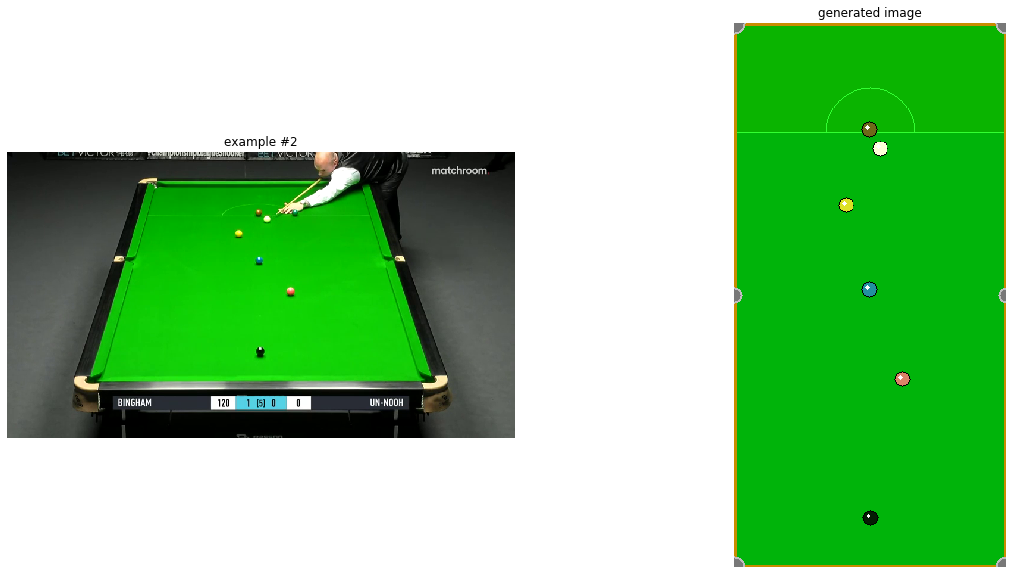

In [20]:
frame3_detect = find_balls(frame3) # find balls in frame3

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame3)
plt.title('example #2')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(frame3_detect)
plt.title('generated image')
plt.axis('off')
plt.show()

#### * Ball merge with other objects

In some cases, the model does not detect balls even if they are seen.

when some other object is around a ball the model can sometimes miss it because it is based on calculating each ball's contour shape.

---

lets look at the last example, another frame from the video:

#### Example #3

cases where model detects false balls

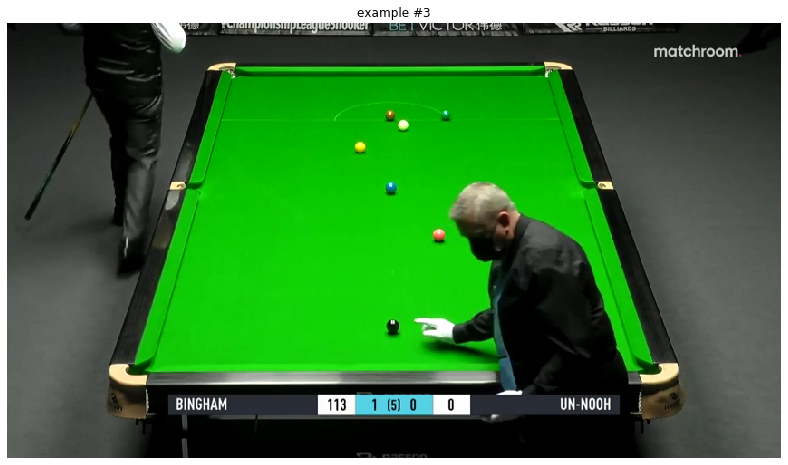

In [21]:
plt.figure(figsize=(16,8))
plt.imshow(frame4)
plt.title('example #3')
plt.axis('off')
plt.show()

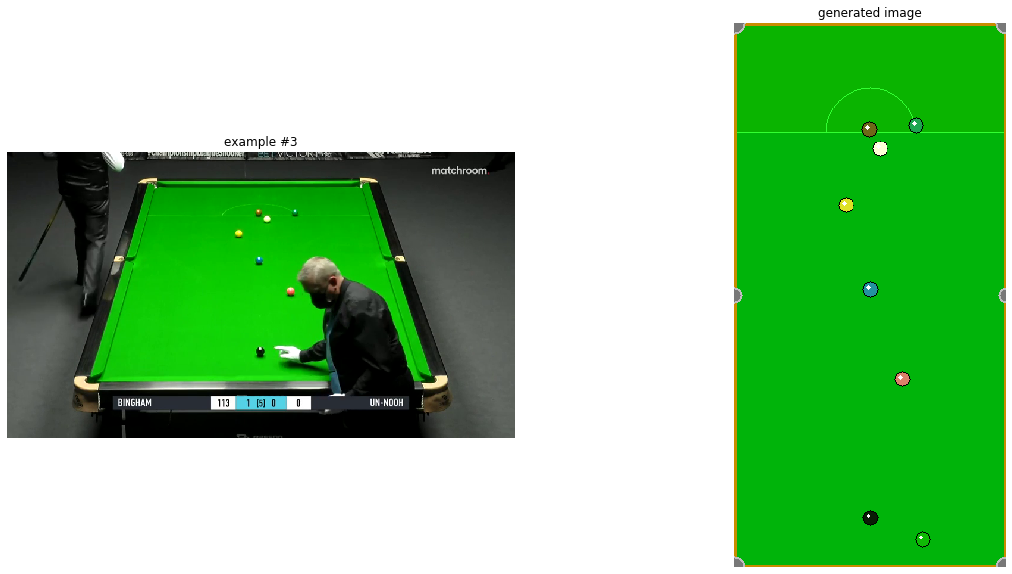

In [22]:
frame4_detect = find_balls(frame4) # find balls in frame4

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frame4)
plt.title('example #3')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(frame4_detect)
plt.title('generated image')
plt.axis('off')
plt.show()

#### * False balls:

In some cases, non-ball objects can appear as balls and be drawn in the output image.

the model can sometimes be fooled because its purpose is to detect snooker balls on a snooker table, other objects on table will make its job harder.

---

### Video:

#### calculating new sizes for output images:

- **final output**: frame from original video next to a changing image of steps output throughout the process, next to the final output image:

`new width = frame.width + (2 * 2D_output.width)`

`new height = 2D_output.height`

then multiply results by `scale_percent` and divide by 100 to get a certain percent of original size.

In [23]:
# new sizes (to keep it under 100mb)
frame_zoom = frame[25:425,100:750] # zoom in on snooker table (resolution purposes)
scale_percent = 78 # = percent of original size

W = int((frame_zoom.shape[1] + (2 * width)) * scale_percent / 100) # final output width
H = int((img.shape[0]) * scale_percent / 100) # final output height
final_size = (W,H)

N = 80 # for adding borders to image 

# for text (2 types)
font_params = dict(org = (20,20),
                   fontFace = cv2.FONT_HERSHEY_DUPLEX,
                   fontScale = 0.7,
                   color = (255,255,255), # white color
                   lineType = 1)

font_params2 = dict(org = (20,20),
                   fontFace = cv2.FONT_HERSHEY_DUPLEX,
                   fontScale = 0.7,
                   color = (0,0,0), # black color
                   lineType = 1)


img = create_table() # creates green empty img to represent the 2D top view of the pool table 
frame_num = 0 # counting frames

# video
cap = cv2.VideoCapture('P6_Snooker.mp4')

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # get total frames amount
FPS = cap.get(cv2.CAP_PROP_FPS) # get FPS
fourcc = cv2.VideoWriter_fourcc(*'avc1') # get codec
out = cv2.VideoWriter('final_output_video.mp4',fourcc, FPS, final_size)

# for output (switching image)
flag_frames = [] # indexes of flag frames 
alpha = int(total_frames / 7)    
for i in range(7): 
    flag_frames.append(int(alpha*i%total_frames)) # takes 7 frames which will be flag frames for different images


ret ,frameOld = cap.read()
while(1):
    ret ,frameNew = cap.read()
    if ret == True:

        # zoom + border
        frame_zoom = frameNew[25:425,100:750] # zoom on table
        frameNew_border = cv2.copyMakeBorder(frame_zoom, N, N, 0, 0, cv2.BORDER_CONSTANT) # add borders from top and bot
        
        # warp perspective 
        matrix = cv2.getPerspectiveTransform(pts1,pts2) # getting perspective by both imgs points
        transformed = cv2.warpPerspective(frameNew, matrix, (width,height)) # warps perpectivess
        
        # blur
        transformed_blur = cv2.GaussianBlur(transformed,(5,5),cv2.BORDER_DEFAULT) # blur applied
        
        # mask
        hsv = cv2.cvtColor(transformed_blur, cv2.COLOR_RGB2HSV) # convert to hsv
        mask = cv2.inRange(hsv, lower, upper) # mask
        
        # filter mask
        kernel = np.ones((5,5),np.uint8)
        mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode
        mask_rgb = cv2.cvtColor(mask_closing, cv2.COLOR_GRAY2RGB)
    
    
        # apply threshold
        ret,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # invert mask
       
        # create image with masked objects on table 
        masked_img = cv2.bitwise_and(transformed,transformed, mask=mask_inv) # masked image

        # find contours and filter them
        ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
        
        ctrs_img = draw_rectangles(ctrs,transformed) # detected objects img for output

        ctrs = filter_ctrs(ctrs) # filter contours by sizes and shapes

        ctrs_filt_img = draw_rectangles(ctrs,transformed) # filtered objects img for output

        ctrs_color = find_ctrs_color(ctrs,transformed) # image with colored contours
        ctrs_color = cv2.addWeighted(ctrs_color,0.5,transformed,0.5,0) # contours color image + transformed image
            
        # draw balls and holes
        top_view = draw_balls(ctrs,radius=8,img=transformed) # draw filtered contours (balls)  
        top_view = draw_holes(top_view,color3=(0,140,200)) # (RGB=>BGR)
        
        # adding text to output from previous steps of process
        cv2.putText(frameNew_border,'input', **font_params)
        cv2.putText(transformed,'warp perspective', **font_params)
        cv2.putText(transformed_blur,'blur', **font_params)
        cv2.putText(mask_rgb,'table mask', **font_params2)
        cv2.putText(masked_img,'masked image', **font_params)
        cv2.putText(ctrs_img,'detected objects', **font_params)
        cv2.putText(ctrs_filt_img, 'filtered objects', **font_params)
        cv2.putText(ctrs_color,'average inner color', **font_params)
        cv2.putText(top_view, 'output', **font_params)

        # use flag frames to switch output images:
        # every X frames the output image is going to switch to another one
        if (flag_frames[0] <= frame_num < flag_frames[1]):
            changing = transformed # warp perspective
        elif(flag_frames[1] < frame_num < flag_frames[2]):
            changing = transformed_blur # blur
        elif(flag_frames[2] < frame_num < flag_frames[3]):
            changing = mask_rgb # mask
        elif(flag_frames[3] < frame_num < flag_frames[4]):
            changing = masked_img # masked img
        elif(flag_frames[4] < frame_num < flag_frames[5]):
            changing = ctrs_img # contours
        elif(flag_frames[5] < frame_num < flag_frames[6]):
            changing = ctrs_filt_img # filtered contours
        elif(flag_frames[6] < frame_num):
            changing = ctrs_color # colored contours
        
        # concat and resize output
        final = cv2.hconcat([frameNew_border, changing])
        final = cv2.hconcat([final, top_view])
        final = cv2.resize(final, final_size, interpolation = cv2.INTER_AREA)

        cv2.imshow('final',final)
        out.write(final) # save final vid
        
        frame_num += 1 # frame counter ++
        k = cv2.waitKey(1) & 0xff 
        if k == 27:
            break
    else:
        break

cap.release() # release input video
out.release() # release output video 
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);